## 재귀 한계에 도달하기 전에 상태를 반환하는 방법
그래프 재귀 제한을 설정하면 그래프 실행 시간을 제어하는데 도움이 되지만, 재귀 제한에 도달하면 그래프에서 오류가 발생

이는 모든 사용 사례에 적합하지 않을 수 있음

대신 재귀 제한에 도달하기 직전의 상태 값을 반환하는 것이 좋음

### 상태를 반환하지 않고
항상 재귀 한계에 도달하는 더미 그래프 정의

상태를 반환하지 않고 더미 그래프를 구현하여 재귀 한계에 도달하는지 확인

   - ReAct 아키텍처를 기반으로 하지만, 실제로 결정을 내리고 조치를 취하는 대신 무한 반복


In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph import START, END

class State(TypedDict):
    value: str
    action_result: str

def router(state: State):
    if state["value"] == "end":
        return END
    else:
        return "action"

def decision_node(state):
    return {"value": "keep going!"}

def action_node(state: State):
    # Do your action here ...
    return {"action_result": "what a great result!"}

workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()

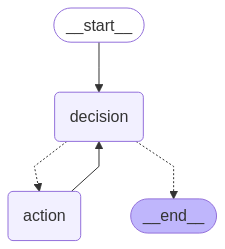

In [2]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [3]:
from langgraph.errors import GraphRecursionError

try:
    app.invoke({"value": "hi!"})
except GraphRecursionError:
    print("Recursion Error")

Recursion Error


### 상태를 반환
재귀 한계에 도달하지 않기 위해 상태에 `remaining_steps`라는 새로운 키를 도입

이 키는 재귀 한계에 도달할 때까지 단계 수를 추적

그런 다음 `remaining_steps`의 값을 확인하여 그래프 실행을 종료하고 `RecursionError`를 발생시키지 않고 상태를 사용자에게 반환해야 할지 여부를 결정할 수 있습니다.

이를 위해 특별한 애노테이션 `RemainingSteps`를 사용
- 내부적으로 특별한 `ManagedValue` 채널을 생성
- 이 채널은 그래프 실행 시간동안만 존재하고 더이상 존재하지 않는 상태 채널

액션 노드는 항상 이후에 결정(decision) 노드를 호출하기 때문에, 그래프에 최소 2개의 추가 단계를 유발하게 됩니다.

따라서 이 채널을 사용하여 제한(limit)에 2단계 이내로 접근했는지를 확인할 것입니다.

이제 그래프를 실행하면, 오류 없이 재귀 한계에 도달하기 직전의 상태 마지막 값을 얻을 수 있어야 합니다.

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from typing import Annotated

from langgraph.managed.is_last_step import RemainingSteps

class State(TypedDict):
    value: str
    action_result: str
    remaining_steps: RemainingSteps

def router(state: State):
    # Force the agent to end
    if state["remaining_steps"] <= 2:
        return END
    if state["value"] == "end":
        return END
    else:
        return "action"

def decision_node(state):
    return {"value": "keep going!"}

def action_node(state: State):
    # Do your action here ...
    return {"action_result": "what a great result!"}

workflow = StateGraph(State)
workflow.add_node("decision", decision_node)
workflow.add_node("action", action_node)
workflow.add_edge(START, "decision")
workflow.add_conditional_edges("decision", router, ["action", END])
workflow.add_edge("action", "decision")
app = workflow.compile()

In [5]:
app.invoke({"value": "hi!"})

{'value': 'keep going!', 'action_result': 'what a great result!'}